# Generalized Linear Models

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.optimize import minimize
from scipy.stats import poisson, binom

## Logistic Regression

### The Binoial Distribution

In [2]:
np.random.seed(123)

# produces a count whose mean is n*p
np.random.binomial(n = 100, p = .75, size = 6)

# produces a binary 0, 1 as seen in logistic regression target (with mean p)
np.random.binomial(n = 1, p = .75, size = 6) 

array([0, 1, 1, 1, 1, 1])

### Odds Ratios

In [ ]:
def calculate_odds_ratio(p_1, p_2):
    odds_1 = p_1 / (1 - p_1)
    odds_2 = p_2 / (1 - p_2)
    odds_ratio = odds_2 / odds_1
    
    return pd.DataFrame({
        'value': ['1', '2'],
        'p': [p_1, p_2],
        'odds': [odds_1, odds_2],
        'log_odds': [np.log(odds_1), np.log(odds_2)],
        'odds_ratio': [np.nan, odds_ratio]
    })

result_A = calculate_odds_ratio(.5, .6)
result_B = calculate_odds_ratio(.1, .2)  
result_C = calculate_odds_ratio(.9, .8)  # inverse of the .1, .2 example

result_A

### Logistic Regression Model

In [4]:
df_reviews = pd.read_csv('https://tinyurl.com/moviereviewsraw')

# for the by-hand option later
X = (
    df_reviews[['word_count', 'gender']]
    .rename(columns = {'gender': 'male'})
    .assign(male = np.where(df_reviews[['gender']] == 'male', 1, 0))
)

y = df_reviews['rating_good']

In [5]:
model_logistic = smf.glm(
    'rating_good ~ word_count + gender', 
    data = df_reviews,
    family = sm.families.Binomial()
).fit()

model_logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            rating_good   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -628.70
Date:                Mon, 14 Oct 2024   Deviance:                       1257.4
Time:                        16:16:34   Pearson chi2:                 1.02e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1068
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7124      0.181      9.442      0.000       1.357       2.068
gender[T.male]     0.1189      0.138      0.865      0.387      -0.151       0.388
word_count        -0.1464      0.016     -9.436      0.000      -0.177      -0.116
==================================================================================
"""

## Poisson Regression Model

<Axes: >

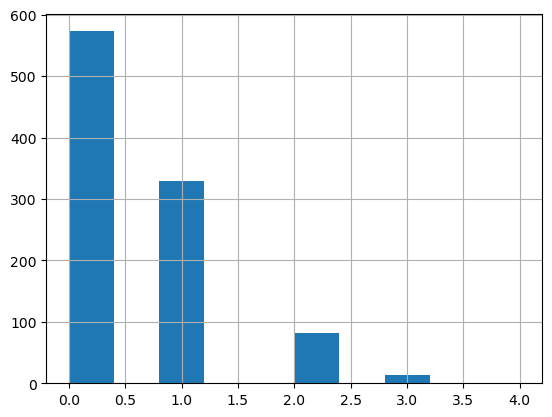

In [6]:
df_reviews['poss_pronoun'] = (
    df_reviews['review_text']
    .str.count('\\bI\\b|\\bme\\b|\\b[Mm]y\\b|\\bmine\\b|\\bmyself\\b')
    )

df_reviews['poss_pronoun'].hist()

In [8]:
model_poisson = smf.glm(
    formula = 'poss_pronoun ~ word_count + gender',
    data = df_reviews,
    family = sm.families.Poisson()
).fit()

model_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           poss_pronoun   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -847.43
Date:                Mon, 14 Oct 2024   Deviance:                       775.38
Time:                        16:16:43   Pearson chi2:                     717.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1981
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.8877      0.109    -17.395      0.000      -2.100      -1.675
gender[T.male]     0.0798      0.088      0.906      0.365      -0.093       0.252
word_count         0.1036      0.006     16.053      0.000       0.091       0.116
==================================================================================
"""

In [9]:
np.exp(model_poisson.params)

Intercept         0.151424
gender[T.male]    1.083073
word_count        1.109207
dtype: float64

## DIY

In [7]:
def glm_simple(par, X, y, family = 'binomial'):
    # add an column for the intercept
    X = np.column_stack((np.ones(X.shape[0]), X))

    # Calculate the linear predictor
    mu = X @ par  # @ is matrix multiplication
    
    # get the likelihood for the binomial or poisson distribution
    if family == 'binomial':
        p = 1 / (1 + np.exp(-mu))
        L = binom.logpmf(y, 1, p)
    elif family == 'poisson':
        lambda_ = np.exp(mu)
        L = poisson.logpmf(y, lambda_)
    
    # return the negative sum of the log-likelihood (for minimization)
    value = -np.sum(L)
    
    return value

Logistic Model

In [ ]:
init = np.zeros(X.shape[1] + 1)

fit_logistic = minimize(
    fun = glm_simple,
    x0 = init,
    args = (X, y),
    method = 'BFGS'
)

fit_logistic['x']

Poission Model

In [ ]:
fit_poisson = minimize(
    fun = glm_simple,
    x0 = init,
    args = (
        X, 
        df_reviews['poss_pronoun'], 
        'poisson'
    )
)

fit_poisson['x']